## OOI Lab Manual 2025: Lab 7 Water Masses: Activity 2 Profiler 

This notebook demonstrates how to access and process the dataset used in *Lab 7 Water Masses* in the 2025 edition of the *OOI Lab Manual*.

By Sage Lichtenwalner, Rutgers University

Revised: January 17, 2025

In [1]:
# Notebook Setup
from erddapy import ERDDAP
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
# Setup a connection to the OOI ERDDAP server
server = "https://erddap.dataexplorer.oceanobservatories.org/erddap/"
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="csv",
)

## Activity 2 - Gulf Stream Influences
In this activity, we will plot about 2 months of data from a profiling CTD and a surface CTD to look at the drastic changes due to a Gulf Stream ring influence in the Pioneer MAB Array.  We will use data from the Coastal Pioneer MAB Northern Profiler Mooring.
* Profiler: CP13NOPM-WFP01-03-CTDPFK000
* Surface Buoy: CP13NOPM-SBI01-02-CTDMOS011

In [3]:
# Load the data for the profiler
url_profiler = e.get_download_url(
  dataset_id='ooi-cp13nopm-wfp01-03-ctdpfk000',
  variables=['time', 'z', 'sea_water_temperature_profiler_depth_enabled', 'sea_water_practical_salinity_profiler_depth_enabled'],
  constraints={"time>=": "2024-04-17", "time<=": "2024-06-04"}
)
df_profiler = pd.read_csv(url_profiler, index_col='time', parse_dates=True, skiprows=[1])


In [4]:
# Flip the depth values
df_profiler['z'] = -df_profiler['z']

# Bin the data to 6 hours and 1 meters
df_profiler['time_bin'] = df_profiler.index.floor('6h')
df_profiler['depth_bin'] = df_profiler['z'].round(1)

# Group by the binned time and depth, then calculate the mean
df_profiler_binned = df_profiler.groupby(['time_bin', 'depth_bin']).mean().reset_index()

# Trim the binned data to depth values between 28 and 75
df_profiler_binned = df_profiler_binned[(df_profiler_binned['depth_bin'] >= 28) & (df_profiler_binned['depth_bin'] <= 75)]

# Pivot the dataframe to have depth as columns and time as index for temperature and salinity
df_profiler_pivot_temp = df_profiler_binned.pivot(index='time_bin', columns='depth_bin', values='sea_water_temperature_profiler_depth_enabled')
df_profiler_pivot_sal = df_profiler_binned.pivot(index='time_bin', columns='depth_bin', values='sea_water_practical_salinity_profiler_depth_enabled')


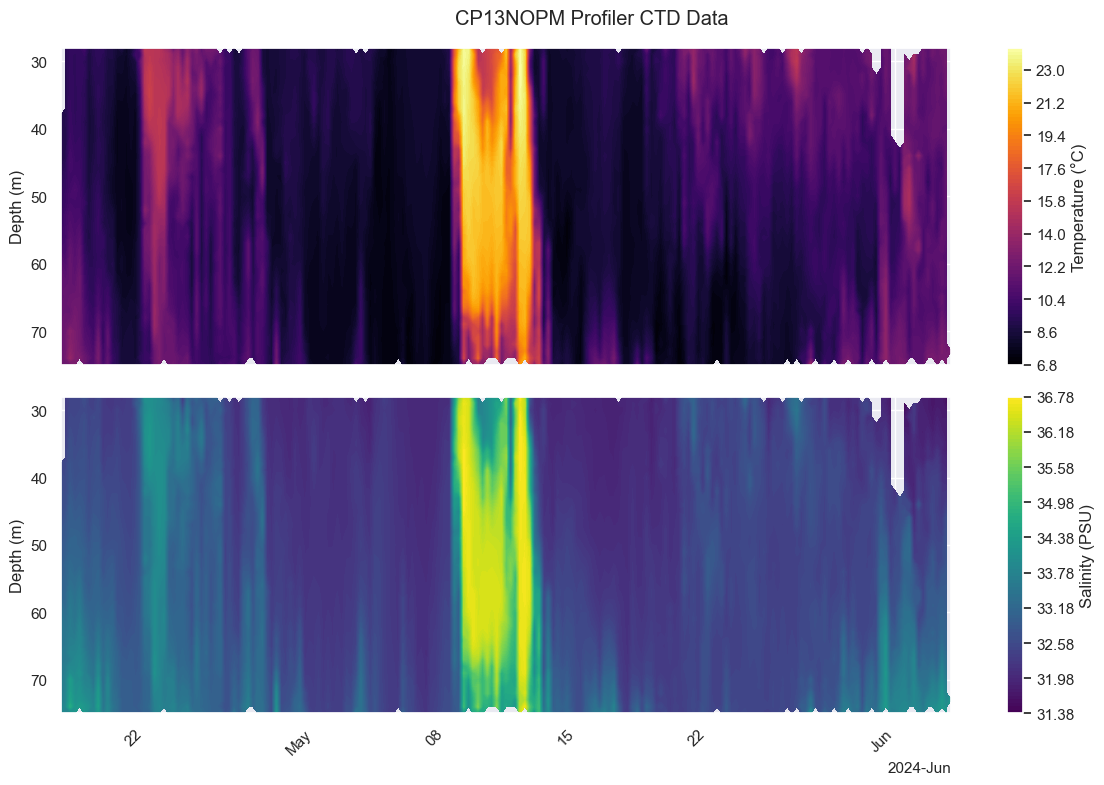

In [5]:
import matplotlib.dates as mdates

# Plot the data as filled contours
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

time_bin = mdates.date2num(df_profiler_pivot_temp.index)
depth_bin = df_profiler_pivot_temp.columns.values
temperature = df_profiler_pivot_temp.T.values
salinity = df_profiler_pivot_sal.T.values

# Temperature plot
contour1 = ax1.contourf(time_bin, depth_bin, temperature, cmap='inferno', levels=100)
fig.colorbar(contour1, ax=ax1, label='Temperature (°C)')
ax1.set_ylabel('Depth (m)')
ax1.invert_yaxis()  # Invert y-axis to have depth increasing downwards

# Fix the time tick labels for temperature plot
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Salinity plot
contour2 = ax2.contourf(time_bin, depth_bin, salinity, cmap='viridis', levels=100)
fig.colorbar(contour2, ax=ax2, label='Salinity (PSU)')
ax2.set_ylabel('Depth (m)')
# ax2.invert_yaxis()  # Invert y-axis to have depth increasing downwards

# Fix the time tick labels for salinity plot
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.suptitle('CP13NOPM Profiler CTD Data')
fig.tight_layout()
plt.show()

In [6]:
import json

# Save the data to JSON
# time_bin_iso = [mdates.num2date(tb).isoformat() for tb in time_bin]
time_bin_simple = [mdates.num2date(tb).strftime('%Y-%m-%d %H:%M') for tb in time_bin]
data = {
    'date': time_bin_simple,
    'depth_bin': depth_bin.tolist(),
    'temperature': np.where(np.isnan(temperature), None, temperature.round(3)).tolist(),
    'salinity': np.where(np.isnan(salinity), None, salinity.round(3)).tolist(),
}

with open('data/lab7_profiler.json', 'w') as f:
    json.dump(data, f, allow_nan=False) 

## Plotly Prototype 
Let's recreate the image above in Plotly

In [7]:
from plotly.subplots import make_subplots

import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=('Temperature (°C)', 'Salinity (PSU)'))

# Add temperature heatmap
fig.add_trace(
    go.Heatmap(
        x=time_bin_simple,
        y=depth_bin,
        z=temperature,
        colorscale='Inferno',
        colorbar=dict(title='Temperature (°C)'),
        colorbar_len=0.5,
        colorbar_y = 0.8,
    ),
    row=1, col=1
)

# Add salinity heatmap
fig.add_trace(
    go.Heatmap(
        x=time_bin_simple,
        y=depth_bin,
        z=salinity,
        colorscale='Viridis',
        colorbar=dict(title='Salinity (PSU)'),
        colorbar_len=0.5,
        colorbar_y = 0.2,
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    title='CP13NOPM Profiler CTD Data',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Depth (m)', autorange='reversed'),
    yaxis2=dict(title='Depth (m)', autorange='reversed'),
    margin=dict(l=0, r=0, t=50, b=50),
)

fig.show()

## Surface Buoy Fixed CTD
For this activity, we also want to include a timeseries of the fixed CTD on the Northern Profiler Mooring Surface Buoy.

Unfortunately, as of 1/27/25, this dataset is not currently available on Erddap, so we will have to use the Netcdf file from the data portal and use that instead.

In [8]:
# Grab the CTD data via Erddap
# url_surface = e.get_download_url(
#   dataset_id='ooi-cp13nopm-sbi01-02-ctdmos011',
#   variables=['time', 'sea_water_temperature', 'sea_water_practical_salinity', 'sea_water_pressure', 'sea_water_density'],
#   constraints={"time>=": "2024-04-17", "time<=": "2024-06-04"}
# )
# df_surface = pd.read_csv(url_surface, index_col='time', parse_dates=True, skiprows=[1])

In [34]:
import xarray as xr
ctd = xr.open_dataset('data/deployment0001_CP13NOPM-SBI01-02-CTDMOS011-telemetered-ctdmo_ghqr_imodem_instrument_20240417T133731-20240604T213731.nc')
ctd.head()

<xarray.Dataset> Size: 1kB
Dimensions:                                            (obs: 5)
Coordinates:
  * obs                                                (obs) int32 20B 0 1 2 3 4
    depth                                              (obs) float64 40B ...
    time                                               (obs) datetime64[ns] 40B ...
Data variables: (12/25)
    sea_water_pressure                                 (obs) float64 40B ...
    sea_water_electrical_conductivity_qartod_results   (obs) uint8 5B ...
    ctd_time                                           (obs) datetime64[ns] 40B ...
    driver_timestamp                                   (obs) datetime64[ns] 40B ...
    id                                                 (obs) |S36 180B ...
    conductivity                                       (obs) float64 40B ...
    ...                                                 ...
    sea_water_temperature                              (obs) float64 40B ...
    sea_water_density                                  (obs) float64 40B ...
    sea_water_pressure_qartod_results                  (obs) uint8 5B ...
    sea_water_electrical_conductivity_qartod_executed  (obs) <U1 20B ...
    sea_water_electrical_conductivity                  (obs) float64 40B ...
    sea_water_practical_salinity_qartod_executed       (obs) <U1 20B ...
Attributes: (12/70)
    node:                               SBI01
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             ctdmo_ghqr_imodem_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                36.179
    lon:                                -74.82612

In [38]:
# Resample the data to hourly averages
ctd_hourly = ctd.resample(time='1h').mean()

# Extract the necessary data
time_hourly = ctd_hourly['time'].values
temperature_hourly = ctd_hourly['sea_water_temperature'].values
salinity_hourly = ctd_hourly['sea_water_practical_salinity'].values
density_hourly = ctd_hourly['sea_water_density'].values

# Convert time to a simple string format
# time_hourly_simple = [str(t) for t in time_hourly]
time_hourly_simple = [mdates.num2date(t).strftime('%Y-%m-%d %H:%M') for t in mdates.date2num(time_hourly)]

# Prepare data for JSON export
data_hourly = {
    'date': time_hourly_simple,
    'temperature': np.where(np.isnan(temperature_hourly), None, temperature_hourly.round(3)).tolist(),
    'salinity': np.where(np.isnan(salinity_hourly), None, salinity_hourly.round(3)).tolist(),
    'density': np.where(np.isnan(density_hourly), None, density_hourly.round(3)).tolist(),
}

# Export to JSON
with open('data/lab7_surface_ctd_hourly.json', 'w') as f:
    json.dump(data_hourly, f, allow_nan=False)


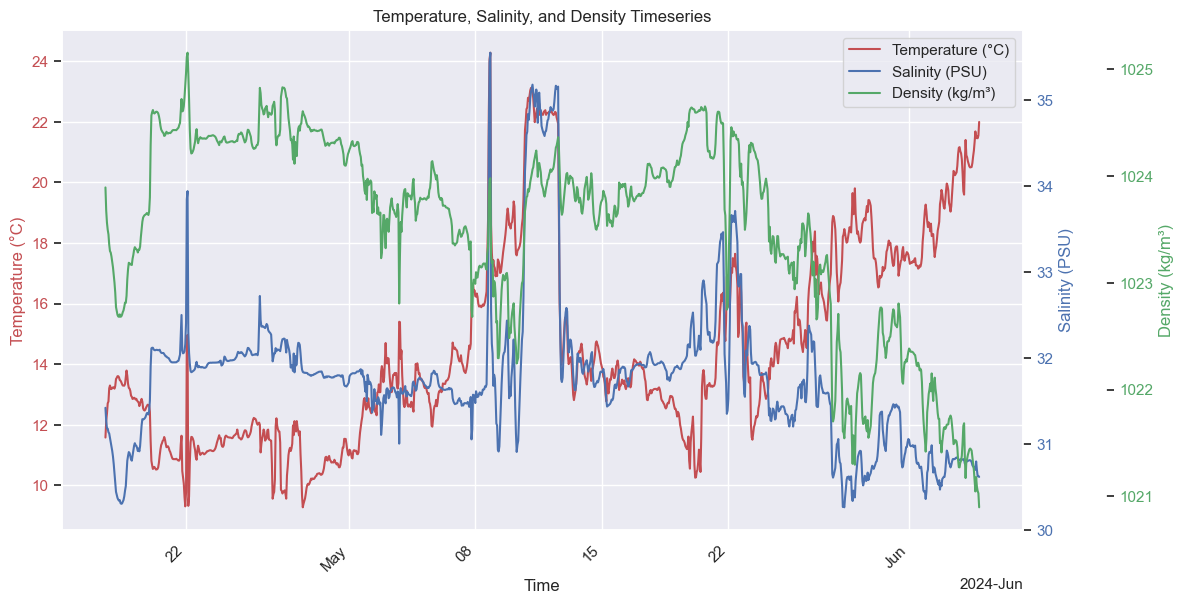

In [36]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature
ax1.plot(time_hourly, temperature_hourly, 'r-', label='Temperature (°C)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature (°C)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis for salinity
ax2 = ax1.twinx()
ax2.plot(time_hourly, salinity_hourly, 'b-', label='Salinity (PSU)')
ax2.set_ylabel('Salinity (PSU)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Create a third y-axis for density
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(time_hourly, density_hourly, 'g-', label='Density (kg/m³)')
ax3.set_ylabel('Density (kg/m³)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Add a legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Format the x-axis to show dates properly
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax2.grid(False)  # Remove grid lines for the secondary y-axis (salinity)
ax3.grid(False)  # Remove grid lines for the tertiary y-axis (density)

fig.tight_layout()
plt.title('Temperature, Salinity, and Density Timeseries')
plt.show()

In [17]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add temperature line
fig.add_trace(go.Scatter(
    x=time,
    y=temperature,
    mode='lines',
    name='Temperature (°C)',
    line=dict(color='red')
))

# Add salinity line
fig.add_trace(go.Scatter(
    x=time,
    y=salinity,
    mode='lines',
    name='Salinity (PSU)',
    yaxis='y2',
    line=dict(color='blue')
))

# Add density line
fig.add_trace(go.Scatter(
    x=time,
    y=density,
    mode='lines',
    name='Density (kg/m³)',
    yaxis='y3',
    line=dict(color='green')
))

# Update layout for multiple y-axes
fig.update_layout(
    title='Temperature, Salinity, and Density Timeseries',
    xaxis=dict(
        title='Time',
        tickformat='%Y-%m-%d %H:%M',
        tickangle=45
    ),
    yaxis=dict(
        title='Temperature (°C)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red')
    ),
    yaxis2=dict(
        title='Salinity (PSU)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        anchor='x',
        overlaying='y',
        side='right'
    ),
    yaxis3=dict(
        title='Density (kg/m³)',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
        anchor='free',
        overlaying='y',
        side='right',
        position=1
    ),
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.5)'
    )
)

fig.show()